# Оценка способности потенциального заёмщика вернуть кредит банку

# Описание задачи

Имеются статистические данные о платёжеспособности клиентов. Требуется определить факторы, такие как сеймейное положение и количество детей, влияющие на возврат кредита в срок.

# План работы

1. Обзор данных
    1. Чтение файла с данными. Оценка содержимого и размера прочитанной таблицы
2. Предобработка данных
    1. Обработка аномальных значений
    2. Обработка пропусков
    3. Замена типа данных
    4. Обработка дубликатов
    5. Лемматизация
    6. Категоризация данных
3. Анализ факторов, влияющих на возврат кредита в срок
4. Общий вывод

# Описание данных

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

# Обзор данных

## Чтение файла с данными. Оценка содержимого и размера прочитанной таблицы.

In [1018]:
#Импорт библиотек.
import pandas as pd
import numpy as np
import matplotlib as plt
import pymorphy3

In [1019]:
# Чтение файла с данными и просмотр сводной информации о таблице.
data = pd.read_csv('datasets/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Из вышеприведённой таблицы видно, что всего в ней 21525 записей, а в столбцах "days_employed" и "total_income" присутствуют только по 19351 записи. Во всех остальных столбцах количество записей равно размеру таблицы. Следовательно, стоит искать пропуски в столбцах "days_employed" и "total_income".

In [1020]:
#Изучение содержимого первых 10 строк таблицы
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


**Вывод**

По содержимому таблицы в первых 10 строках видно, что значение трудового стажа указано с дробной частью и местами со знаком минус. Также местами значение трудового стажа доходит до аномальных значений. Образование в таблице указывается без единого регистра, то есть можно встретить как "среднее", так и "Среднее", а также "СРЕДНЕЕ" образование. Это недопустимо, все значения далее будут приведены к единому регистру.

# Предобработка данных

## Обработка аномальных значений

Перед дальнейшей обработкой пропусков избавимся от отрицательных и аномальных значений в столбце days_employed взяв данные по модулю.

In [1021]:
#Избавление от отрицательных значений трудового стажа
data['days_employed'] = abs(data['days_employed'])

Исследуем значения столбца days_employed детальнее.

In [1022]:
data['days_employed'].describe()

count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

Максимальное значение трудового стажа составляет 401755 дней, что составляет больше 1000 лет, это аномальное значение. Проверим данные в этом столбце на наличие выбросов.

<Axes: >

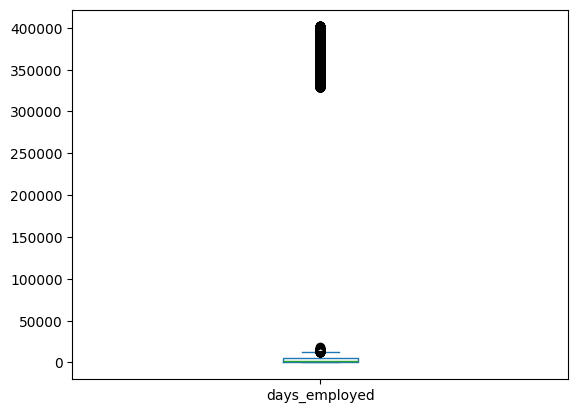

In [1023]:
data['days_employed'].plot(kind='box')

В столбце days_employed имеются выбросы. Заполним аномальные значения стажа пропусками NaN чтобы потом вместе с остальными пропусками заполнить их медианными значениями. Для этого сначала создадим функцию заполнения аномальных значений пропусками.

In [1024]:
def vybrosy_del(data,column):
    q25=np.array(data[column].quantile(0.25))
    
    q75=np.array(data[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(data[column].index,data[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк для заполнения пропусками в '+ str(column) + ':', len(del_index))
    return del_index

Далее применим эту функцию

In [1025]:
array_num_col = ["days_employed"]
count = 0 
for column in array_num_col:
    index_del = vybrosy_del(data,column)
    count += len(index_del)
    data.loc[index_del, column] = np.NaN
print("Было заполнено:", count)

Количество строк для заполнения пропусками в days_employed: 3516
Было заполнено: 3516


## Обработка пропусков

Найдем количество пропусков

In [1026]:
display(data.isna().sum())

children               0
days_employed       5690
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Количество пропусков в столбце "days_employed" увеличилось после заполнения пропусками выбросов.

Изучим строки с пропусками

In [1027]:
#Все строки с пропусками в столбцах "days_employed" и "total_income"
display(data[(data['days_employed'].isna()) | (data['total_income'].isna())])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,NaN,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
18,0,NaN,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,NaN,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,NaN,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
...,...,...,...,...,...,...,...,...,...,...,...,...
21508,0,NaN,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638.590915,недвижимость
21509,0,NaN,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029.059379,операции с недвижимостью
21510,2,NaN,28,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,приобретение автомобиля
21518,0,NaN,59,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,153864.650328,сделка с автомобилем


Причины появления пропусков в данных могут быть разными. Например, пользователь мог не указать о себе какие-нибудь 
сведения, или автоматизированная система сбора информации могла дать сбой.

Пропущенные значения заменим на медианы из выборки значений столбца. Если заменять пропуски на средние значения выборки, это, 
скорее всего, даст нам значительное отклонение от фактических значений.

Заменим пропуски в указанных столбцах медианой взятой по нескольким характеристикам клиента - по типу занятости, по образованию и по возрастной группе. Это позволит нам определить наиболее приближенные к фактическим значения.

In [1028]:
# Выполним последовательную группировку по трём характеристикам клиента - типу занятости, образованию и возрасту
data_group_income_type = data.groupby(['income_type', 'education', 'dob_years'])["total_income"].median()

Посмотрим что получилось в результате группировки

In [1029]:
data_group_income_type.head(40)

income_type  education  dob_years
безработный  Высшее     45           202722.511368
             среднее    31            59956.991984
в декрете    СРЕДНЕЕ    39            53829.130729
госслужащий  ВЫСШЕЕ     21           349229.424952
                        24           175195.751491
                        26           179528.083992
                        27           208293.756930
                        28           191092.037741
                        29           108089.602781
                        31           292742.007744
                        32           184967.678506
                        34           108685.967340
                        35           185280.550633
                        36           136824.245650
                        38           134044.429576
                        40           162361.426048
                        42           250978.214319
                        43           350242.246669
                        45           480756.5902

Из вышеприведенной таблицы, первых 40 ее строк, видно, что для некоторых групп медиану вычислить не удалось из-за того, что все значения в группе оказались заполнены пропусками. Например для "госслужащих" с "ВЫСШИМ" образованием, 60 лет, стоит значение NaN.
Из получившейся таблицы брать константы не представляется возможным, так как получается слишком много значений. Поэтому напишем функцию извлекающую значения из этой таблицы. Для извлечения значений медианы из таблицы сгруппированной по трем характеристикам понадобятся сама таблица и эти три характеристики в качестве аргументов

In [1030]:
# Создадим функцию, принимающую в качестве аргументов таблицу с медианами, тип занятости, образование и возраст
# и возвращающую значение медианы для данной категории для заполнения пропусков в столбце "total_income"
def income_type_group3_total_income	(data_income_type, income_type_value, education_value, dob_years_value):
    return data_income_type.loc[income_type_value, education_value, dob_years_value]

Можно проверить как работает функция

In [1031]:
income_type_group3_total_income(data_group_income_type, 'госслужащий', 'ВЫСШЕЕ', 24)

175195.7514909646

Как видно из таблицы значение верное - функция работает верно.

Для замены пропусков с помощью метода apply нам понадобится передавать функции четыре аргумента вместе с таблицей.

In [1032]:
# Функция возвращающая возрастную категорию по значению возраста
def age_categories_func(age):
    if age <= 25: return 'до 25'
    if 25 < age <= 35: return 'от 26 до 35'
    if 35 < age <= 45: return 'от 36 до 45'
    if 45 < age <= 60: return 'от 46 до 60'
    if age > 60: return 'от 61'
    

In [1033]:
# Приведение всех значений в столбце образования к нижнему регистру 
data.education = data.education.str.lower()

In [1034]:
# Создание нового столбца с возрастными категориями, которые определяются по значениям из столбца "возраст"
data['age_categories'] = data['dob_years'].apply(age_categories_func)

In [1035]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     15835 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_categories    21525 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


In [1036]:
#Просмотр сводной таблицы
data.pivot_table(index=['income_type', 'age_categories'], columns='education', values='total_income', aggfunc='median')

education                              высшее      начальное  \
income_type     age_categories                                 
безработный     от 26 до 35               NaN            NaN   
                от 36 до 45     202722.511368            NaN   
в декрете       от 36 до 45               NaN            NaN   
госслужащий     до 25           148996.629480            NaN   
                от 26 до 35     164390.448491  191021.140719   
                от 36 до 45     174957.345503  132191.849854   
                от 46 до 60     183847.630963  105766.403301   
                от 61           233952.871796            NaN   
компаньон       до 25           159291.733847  124320.640472   
                от 26 до 35     197165.262008  131455.738975   
                от 36 до 45     213764.990713  194995.338395   
                от 46 до 60     221348.566557  163403.016785   
                от 61           188400.822321            NaN   
пенсионер       до 25           137674.117012            NaN   
                от 26 до 35     214963.301941            NaN   
                от 36 до 45     169619.794309  112332.918273   
                от 46 до 60     143400.454272  110026.007572   
                от 61           143939.043160   98095.380008   
предприниматель от 26 до 35     499163.144947            NaN   
сотрудник       до 25           134934.796706  152742.882148   
                от 26 до 35     161891.999794  124157.255544   
                от 36 до 45     172602.293435  122114.452405   
                от 46 до 60     171699.598561  130600.077985   
                от 61           174933.507875  164412.796712   
студент         до 25            98201.625314            NaN   

education                       неоконченное высшее        среднее  \
income_type     age_categories                                       
безработный     от 26 до 35                     NaN   59956.991984   
                от 36 до 45                     NaN            NaN   
в декрете       от 36 до 45                     NaN   53829.130729   
госслужащий     до 25                 135252.995358  135023.973156   
                от 26 до 35           156388.620171  141532.517774   
                от 36 до 45           174803.231306  135350.142556   
                от 46 до 60           266011.945539  134189.711629   
                от 61                           NaN  143847.253036   
компаньон       до 25                 141932.179972  135891.639552   
                от 26 до 35           177633.929267  159165.567457   
                от 36 до 45           213744.325082  163115.068645   
                от 46 до 60           219164.136223  158899.868414   
                от 61                 189610.009306  173896.618274   
пенсионер       до 25                           NaN  100121.194356   
                от 26 до 35                     NaN   96116.021663   
                от 36 до 45            34466.133539  124440.429591   
                от 46 до 60           112018.336684  118228.074585   
                от 61                 145557.484323  111743.076949   
предприниматель от 26 до 35                     NaN            NaN   
сотрудник       до 25                 134925.188145  123717.918962   
                от 26 до 35           158116.053707  133938.686944   
                от 36 до 45           163675.468278  140501.784542   
                от 46 до 60           167686.286724  136253.671561   
                от 61                 229339.200509  133299.194693   
студент         до 25                           NaN            NaN   

education                       ученая степень  
income_type     age_categories                  
безработный     от 26 до 35                NaN  
                от 36 до 45                NaN  
в декрете       от 36 до 45                NaN  
госслужащий     до 25                      NaN  
                от 26 до 35                NaN  
                от 36 до 45      1113

In [1037]:
#Получение сводной таблицы 
data_pivot = data.pivot_table(index=['income_type', 'age_categories'], columns='education', values='total_income', aggfunc='median')

In [1038]:
# Описание функции возвращающей медиану и проверка ее работы
def super_fillna_func(income_type, age_categories, education):
    '''
    Находит в таблице data нужную медиану.
    '''
    try:
        return data_pivot.loc[(income_type, age_categories)][education]
    except:
        return 0
print(super_fillna_func('студент', 'до 25','высшее') )     

98201.62531401133


In [1039]:
# Создание нового столбца с медианными значениями столбца total_income
data['new_income'] = data.apply(lambda row: super_fillna_func(row['income_type'], row['age_categories'], row['education']), axis=1)

# Заполнение столбца total_income на основе значений столбца new_income
data['total_income'] = data['total_income'].fillna(data['new_income'])

In [1040]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     15835 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21524 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_categories    21525 non-null  object 
 13  new_income        21524 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 2.3+ MB


В столбце "total_income" остался один пропуск. Посмотрим запись с этим пропуском.

In [1041]:
data[data['total_income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_categories,new_income
8142,0,NaN,64,начальное,3,гражданский брак,1,F,госслужащий,0,NaN,сыграть свадьбу,от 61,NaN


Параметры данной записи в сводной таблице полученной выше дают нам значение NaN. Очевидно, что NaN получается потому что в группе в столбце total_income присутствуют одни пропуски. Проверим это предположение выведя все записи с текущими параметрами.

In [1042]:
data[(data['income_type'] == 'госслужащий') & (data['age_categories'] == 'от 61') & (data['education'] == 'начальное')]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_categories,new_income
8142,0,NaN,64,начальное,3,гражданский брак,1,F,госслужащий,0,NaN,сыграть свадьбу,от 61,NaN


Медиана считается в группе с одним объектом c пропуском в столбце total_income и поэтому получается равной NaN. Для заполнения пропуска возьмем медиану из группы с той же занятостью, той же возрастной категории и ближайшим к начальному образованием.

In [1043]:
data.loc[(data['total_income'].isna()), 'total_income']=super_fillna_func('госслужащий', 'от 61','среднее')

In [1044]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     15835 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_categories    21525 non-null  object 
 13  new_income        21524 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 2.3+ MB


Теперь пропусков в столбце total_income нет. Остались пропуски в столбце days_employed.

In [1045]:
data.pivot_table(index=['income_type', 'age_categories'], columns='education', values='days_employed', aggfunc='median')

education                            высшее    начальное  неоконченное высшее  \
income_type     age_categories                                                  
в декрете       от 36 до 45             NaN          NaN                  NaN   
госслужащий     до 25           1211.124543          NaN           569.104305   
                от 26 до 35     1864.901726   760.901517          2297.801475   
                от 36 до 45     3869.820084  1672.633661          3500.323779   
                от 46 до 60     4141.630427  4193.718465          1643.155616   
                от 61           3717.274125          NaN                  NaN   
компаньон       до 25            822.164196  1180.618510           749.841414   
                от 26 до 35     1188.774514   682.177316           992.122926   
                от 36 до 45     1684.041245  2146.950218          1566.826499   
                от 46 до 60     1916.355500  1151.634460          1581.687051   
                от 61           2350.897005          NaN           927.335994   
предприниматель от 26 до 35      520.848083          NaN                  NaN   
сотрудник       до 25            722.194948   849.989871           731.999015   
                от 26 до 35     1350.336971  1292.411432          1203.830172   
                от 36 до 45     1958.647477  1058.945815          1391.450290   
                от 46 до 60     2024.157707  1342.523267          2070.709589   
                от 61           2674.713083  4053.359572          3551.828180   
студент         до 25            578.751554          NaN                  NaN   

education                           среднее  ученая степень  
income_type     age_categories                               
в декрете       от 36 до 45     3296.759962             NaN  
госслужащий     до 25           1194.903719             NaN  
                от 26 до 35     1961.230415             NaN  
                от 36 до 45     3062.038243     5968.075884  
                от 46 до 60     3397.569149             NaN  
                от 61           2219.855114             NaN  
компаньон       до 25            745.688380             NaN  
                от 26 до 35     1393.491585             NaN  
                от 36 до 45     1757.344692             NaN  
                от 46 до 60     2110.186400             NaN  
                от 61           2279.986189             NaN  
предприниматель от 26 до 35             NaN             NaN  
сотрудник       до 25            907.079891             NaN  
                от 26 до 35     1330.725397             NaN  
                от 36 до 45     1791.040318     1380.316041  
                от 46 до 60     2142.827443     5352.038180  
                от 61           2295.468279             NaN  
студент         до 25                   NaN             NaN

In [1046]:
#Получение сводной таблицы
data_pivot = data.pivot_table(index=['income_type', 'age_categories'], columns='education', values='days_employed', aggfunc='median')
data_pivot.loc[('студент', 'до 25')]['высшее']

578.7515535382181

In [1047]:
# Создание нового столбца с медианными значениями столбца days_employed
data['new_days_employed'] = data.apply(lambda row: super_fillna_func(row['income_type'], row['age_categories'], row['education']), axis=1)

# Заполнение столбца days_employed на основе значений столбца new_days_employed
data['days_employed'] = data['days_employed'].fillna(data['new_days_employed'])

In [1048]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21525 non-null  int64  
 1   days_employed      21524 non-null  float64
 2   dob_years          21525 non-null  int64  
 3   education          21525 non-null  object 
 4   education_id       21525 non-null  int64  
 5   family_status      21525 non-null  object 
 6   family_status_id   21525 non-null  int64  
 7   gender             21525 non-null  object 
 8   income_type        21525 non-null  object 
 9   debt               21525 non-null  int64  
 10  total_income       21525 non-null  float64
 11  purpose            21525 non-null  object 
 12  age_categories     21525 non-null  object 
 13  new_income         21524 non-null  float64
 14  new_days_employed  21524 non-null  float64
dtypes: float64(4), int64(5), object(6)
memory usage: 2.5+ MB


В столбце "days_employed" остался один пропуск. Посмотрим запись с этим пропуском.

In [1049]:
data[data['days_employed'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_categories,new_income,new_days_employed
8142,0,NaN,64,начальное,3,гражданский брак,1,F,госслужащий,0,143847.253036,сыграть свадьбу,от 61,NaN,NaN


Параметры данной записи в сводной таблице полученной выше дают нам значение NaN. Очевидно, что NaN получается потому что в группе в столбце days_employed присутствуют одни пропуски. Проверим это предположение выведя все записи с текущими параметрами.

In [1050]:
data[(data['income_type'] == 'госслужащий') & (data['age_categories'] == 'от 61') & (data['education'] == 'начальное')]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_categories,new_income,new_days_employed
8142,0,NaN,64,начальное,3,гражданский брак,1,F,госслужащий,0,143847.253036,сыграть свадьбу,от 61,NaN,NaN


Медиана считается в группе с одним объектом c пропуском в столбце days_employed и поэтому получается равной NaN. Для заполнения пропуска возьмем медиану из группы с той же занятостью, той же возрастной категории и ближайшим к начальному образованием.

In [1051]:
data.loc[(data['days_employed'].isna()), 'days_employed']=super_fillna_func('госслужащий', 'от 61','среднее')

In [1052]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21525 non-null  int64  
 1   days_employed      21525 non-null  float64
 2   dob_years          21525 non-null  int64  
 3   education          21525 non-null  object 
 4   education_id       21525 non-null  int64  
 5   family_status      21525 non-null  object 
 6   family_status_id   21525 non-null  int64  
 7   gender             21525 non-null  object 
 8   income_type        21525 non-null  object 
 9   debt               21525 non-null  int64  
 10  total_income       21525 non-null  float64
 11  purpose            21525 non-null  object 
 12  age_categories     21525 non-null  object 
 13  new_income         21524 non-null  float64
 14  new_days_employed  21524 non-null  float64
dtypes: float64(4), int64(5), object(6)
memory usage: 2.5+ MB


## Замена типа данных

In [1053]:
# Выведем общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21525 non-null  int64  
 1   days_employed      21525 non-null  float64
 2   dob_years          21525 non-null  int64  
 3   education          21525 non-null  object 
 4   education_id       21525 non-null  int64  
 5   family_status      21525 non-null  object 
 6   family_status_id   21525 non-null  int64  
 7   gender             21525 non-null  object 
 8   income_type        21525 non-null  object 
 9   debt               21525 non-null  int64  
 10  total_income       21525 non-null  float64
 11  purpose            21525 non-null  object 
 12  age_categories     21525 non-null  object 
 13  new_income         21524 non-null  float64
 14  new_days_employed  21524 non-null  float64
dtypes: float64(4), int64(5), object(6)
memory usage: 2.5+ MB


В столбцах "days_employed" и "total_income" целесообразно изменить вещественный тип данных на целочисленный.

In [1054]:
data['days_employed'] = data['days_employed'].astype('int64')
data['total_income'] = data['total_income'].astype('int64')

Повторный просмотр общей информации о таблице для проверки типов данных столбцов "days_employed" и "total_income"

In [1055]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21525 non-null  int64  
 1   days_employed      21525 non-null  int64  
 2   dob_years          21525 non-null  int64  
 3   education          21525 non-null  object 
 4   education_id       21525 non-null  int64  
 5   family_status      21525 non-null  object 
 6   family_status_id   21525 non-null  int64  
 7   gender             21525 non-null  object 
 8   income_type        21525 non-null  object 
 9   debt               21525 non-null  int64  
 10  total_income       21525 non-null  int64  
 11  purpose            21525 non-null  object 
 12  age_categories     21525 non-null  object 
 13  new_income         21524 non-null  float64
 14  new_days_employed  21524 non-null  float64
dtypes: float64(2), int64(7), object(6)
memory usage: 2.5+ MB


## Обработка дубликатов

In [1056]:
#Подсчет количества дубликатов
data.duplicated().sum()

72

In [1057]:
# Удаление дубликатов с обновлением индексов
data = data.drop_duplicates().reset_index(drop = True)

Чтобы убедиться в удалении дубликатов выполним повторный подсчет их количества.

In [1058]:
# Повторный подсчет количества дубликатов
data.duplicated().sum()

0

Далее будет выполнен поиск дубликатов среди строковых значений. Для этого определим в каких столбцах используются строковые значения, если требуется приведем все строковые значения к единому регистру и выявим дубликаты.

In [1059]:
# Вывод общей информации о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21453 entries, 0 to 21452
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21453 non-null  int64  
 1   days_employed      21453 non-null  int64  
 2   dob_years          21453 non-null  int64  
 3   education          21453 non-null  object 
 4   education_id       21453 non-null  int64  
 5   family_status      21453 non-null  object 
 6   family_status_id   21453 non-null  int64  
 7   gender             21453 non-null  object 
 8   income_type        21453 non-null  object 
 9   debt               21453 non-null  int64  
 10  total_income       21453 non-null  int64  
 11  purpose            21453 non-null  object 
 12  age_categories     21453 non-null  object 
 13  new_income         21452 non-null  float64
 14  new_days_employed  21452 non-null  float64
dtypes: float64(2), int64(7), object(6)
memory usage: 2.5+ MB


Строковые значения используются в столбцах "education", "family_status", "gender", "income_type", "purpose".

In [1060]:
# Уникальные значения в столбце education
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [1061]:
# Уникальные значения в столбце family_status
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [1062]:
# Уникальные значения в столбце gender
data['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [1063]:
# Уникальные значения в столбце income_type
data['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [1064]:
# Уникальные значения в столбце purpose
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Приведение к единому регистру не требуется. Это требовалось только в столбце education и уже было проделано. Следовательно, не требуется и повторно искать дубликаты.

В таблице data столбцы education и education_id являются взаимозаменяемыми. То же самое можно сказать про столбцы family_status и family_status_id. Поэтому стоит удалить дублирующую информацию из таблицы, а именно столбцы education и family_status, предварительно создав датафреймы (словари), сопоставляющие education_id c education и family_status_id с family_status.

Создадим новый датафрейм (словарь) сопоставляющий каждому уникальному значению education уникальное значение education_id и удалим из исходной таблицы стобец education.

In [1065]:
print('Словарь:')
education_dict = data[['education_id', 'education']]
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
data.drop('education', axis = 1, inplace = True)
display(education_dict)

Словарь:


,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


Создадим новый датафрейм (словарь) сопоставляющий каждому уникальному значению family_status уникальное значение family_status_id и удалим из исходной таблицы стобец family_status. А также выведем предыдущую таблицу как с использованием family_status_id, так и снова с помощью family_status.

In [1066]:
print('Словарь:')
family_dict = data[['family_status_id', 'family_status']]
family_dict = family_dict.drop_duplicates().reset_index(drop=True)
data.drop('family_status', axis = 1, inplace = True)
display(family_dict)

Словарь:


,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


Созданные датафреймы можно использовать для извлечения значений следующим образом:

In [1067]:
print('\n\nСгруппированная таблица:')
a = data.groupby('family_status_id')['debt'].agg(['count', 'sum', lambda x: '{:.2%} '.format(x.mean())])
display(a)


# Заменяем
print('\n\nЗаменяем численные значения по ключу словаря:')
a.reset_index().replace({'family_status_id': family_dict.family_status.to_dict()})



Сгруппированная таблица:


,count,sum,<lambda_0>
family_status_id,,,
0,12338,931,7.55%
1,4151,388,9.35%
2,959,63,6.57%
3,1195,85,7.11%
4,2810,274,9.75%




Заменяем численные значения по ключу словаря:


,family_status_id,count,sum,<lambda_0>
0,женат / замужем,12338,931,7.55%
1,гражданский брак,4151,388,9.35%
2,вдовец / вдова,959,63,6.57%
3,в разводе,1195,85,7.11%
4,Не женат / не замужем,2810,274,9.75%


## Лемматизация.

Для каждой записи составим список лемм цели кредита и добавим их в новый столбец "purpose_lemmas"

In [1068]:
morph = pymorphy3.MorphAnalyzer()

In [1069]:
def lemm(text):
    spisok_slov = text.split()
    lemma = []
    for word in spisok_slov:
        lemma.append(morph.normal_forms(word)[0])
    return lemma

In [1070]:
data['purpose_lemmas'] = data['purpose'].apply(lemm) 

In [1071]:
data

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,age_categories,new_income,new_days_employed,purpose_lemmas
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,от 36 до 45,172602.293435,1958.647477,"[покупка, жильё]"
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,от 36 до 45,140501.784542,1791.040318,"[приобретение, автомобиль]"
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,от 26 до 35,133938.686944,1330.725397,"[покупка, жильё]"
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,от 26 до 35,133938.686944,1330.725397,"[дополнительный, образование]"
4,0,0,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,от 46 до 60,118228.074585,0.000000,"[сыграть, свадьба]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21448,1,4529,43,1,1,F,компаньон,0,224791,операции с жильем,от 36 до 45,163115.068645,1757.344692,"[операция, с, жильё]"
21449,0,0,67,1,0,F,пенсионер,0,155999,сделка с автомобилем,от 61,111743.076949,0.000000,"[сделка, с, автомобиль]"
21450,1,2113,38,1,1,M,сотрудник,1,89672,недвижимость,от 36 до 45,140501.784542,1791.040318,[недвижимость]
21451,3,3112,38,1,0,M,сотрудник,1,244093,на покупку своего автомобиля,от 36 до 45,140501.784542,1791.040318,"[на, покупка, свой, автомобиль]"


**Вывод**

В значениях столбца с целями получения кредита были выделены леммы и помещены в новый столбец с названием "purpose_lemmas"

## Категоризация данных

Указанные цели кредита могут совпадать по смыслу, но быть сформулированы по-разному. Опишем одной формулировкой такие цели.

In [1072]:
# Получим уникальные значения столбца 'purpose' и значения, показывающие сколько раз они встречаются
print (data['purpose'].value_counts())

purpose
свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образовани

In [1073]:
# Для каждого значения столбца 'purpose' выделим одно ключевое слово, отражающее цель кредита.
# Сформируем из ключевых слов список
categories_keyword = ["недвижимость", "жильё", "автомобиль", "образование",  "свадьба"]  

Далее сформируем словарь, где ключам соответствуют ключевые слова из предыдущего списка, а значениям - категории цели кредита.

In [1074]:
categories_dict = {"недвижимость": 'операции с недвижимостью', "жильё": 'операции с жильем', "автомобиль": 'операции с автомобилем', 
                   "образование": 'получение образования', "свадьба": 'проведение свадьбы'}

In [1075]:
# Создание списка с категориями цели кредита
categories=[]
def purpose_categories(text):
    for word in categories_dict.keys():
        if word in text:
            categories.append(categories_dict[word])
    return categories

data['purpose_lemmas'].apply(purpose_categories)

0        [операции с жильем, операции с автомобилем, оп...
1        [операции с жильем, операции с автомобилем, оп...
2        [операции с жильем, операции с автомобилем, оп...
3        [операции с жильем, операции с автомобилем, оп...
4        [операции с жильем, операции с автомобилем, оп...
                               ...                        
21448    [операции с жильем, операции с автомобилем, оп...
21449    [операции с жильем, операции с автомобилем, оп...
21450    [операции с жильем, операции с автомобилем, оп...
21451    [операции с жильем, операции с автомобилем, оп...
21452    [операции с жильем, операции с автомобилем, оп...
Name: purpose_lemmas, Length: 21453, dtype: object

In [1076]:
# Добавим сформированный список categories в таблицу как новую колонку 'purpose_categories'
data['purpose_categories'] = categories

In [1077]:
# Проверим содержимое таблицы
data

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,age_categories,new_income,new_days_employed,purpose_lemmas,purpose_categories
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,от 36 до 45,172602.293435,1958.647477,"[покупка, жильё]",операции с жильем
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,от 36 до 45,140501.784542,1791.040318,"[приобретение, автомобиль]",операции с автомобилем
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,от 26 до 35,133938.686944,1330.725397,"[покупка, жильё]",операции с жильем
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,от 26 до 35,133938.686944,1330.725397,"[дополнительный, образование]",получение образования
4,0,0,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,от 46 до 60,118228.074585,0.000000,"[сыграть, свадьба]",проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21448,1,4529,43,1,1,F,компаньон,0,224791,операции с жильем,от 36 до 45,163115.068645,1757.344692,"[операция, с, жильё]",операции с жильем
21449,0,0,67,1,0,F,пенсионер,0,155999,сделка с автомобилем,от 61,111743.076949,0.000000,"[сделка, с, автомобиль]",операции с автомобилем
21450,1,2113,38,1,1,M,сотрудник,1,89672,недвижимость,от 36 до 45,140501.784542,1791.040318,[недвижимость],операции с недвижимостью
21451,3,3112,38,1,0,M,сотрудник,1,244093,на покупку своего автомобиля,от 36 до 45,140501.784542,1791.040318,"[на, покупка, свой, автомобиль]",операции с автомобилем


**Вывод**

Были выведены уникальные значения целей получения кредита из столбца с целями. Многие из этих целей совпадают по смыслу
но сформулированы по-разному. В каждом значении было выделено одно ключевое слово, описывающее цель кредита и помещено в список categories_keyword. В дальнейшем этот список ключевых слов и леммы из столбца "purpose_lemmas" были использованы для заполнения столбца purpose_categories. В этом столбце одинаковые цели с разными формулировками описаны одинаковым образом.

# Анализ факторов, влияющих на возврат кредита в срок

## Определить, вляет ли наличие и количество детей на возврат кредита в срок.

Сформируем таблицу для лиц возвративших кредиты (debt = 0). Посчитаем количество лиц вернувших кредиты по критерию "количество детей". Лица вернувшие кредиты будут сгруппированы по количеству детей

In [1078]:
data_children_debt0 = data[data['debt'] == 0]['children'].value_counts()

In [1079]:
data_children_debt0

children
 0     13028
 1      4363
 2      1858
 3       303
 20       68
-1        46
 4        37
 5         9
Name: count, dtype: int64

В первом столбце мы видим количество детей. Значение "-1" явно ошибочно, как и значение 20.

Исправим в столбце "children" значения -1 на 1. Скорее всего, имелось ввиду значение 1.

In [1080]:
data.loc[data['children']==-1, 'children']=data.loc[data['children']==-1, 'children'].replace(-1,1)

In [1081]:
#Повторно сформируем таблицу для лиц вернувших кредиты
data_children_debt0 = data[data['debt'] == 0]['children'].value_counts()

In [1082]:
#Проверим сформированную таблицу
data_children_debt0

children
0     13028
1      4409
2      1858
3       303
20       68
4        37
5         9
Name: count, dtype: int64

Запись с числом детей 20 удалим, поскольку такое значение, скорее всего ошибочно

In [1083]:
# Удаление записи с числом детей 20
data_children_debt0 = data_children_debt0.drop([20])

In [1084]:
# Повторная проверка таблицы
data_children_debt0

children
0    13028
1     4409
2     1858
3      303
4       37
5        9
Name: count, dtype: int64

Мы видим, что число лиц вернувших кредиты уменьшается с ростом числа детей. Это может быть связано с тем, что 
с ростом числа детей люди меньше берут кредиты

In [1085]:
#Сформируем таблицу для лиц не вернувших кредиты
data_children_debt1 = data[data['debt'] == 1]['children'].value_counts()

In [1086]:
# Проверим сформированную таблицу
data_children_debt1

children
0     1063
1      445
2      194
3       27
20       8
4        4
Name: count, dtype: int64

In [1087]:
# Удалим запись со значением детей 20
data_children_debt1=data_children_debt1.drop([20])

In [1088]:
# Проверим сформированную таблицу повторно
data_children_debt1

children
0    1063
1     445
2     194
3      27
4       4
Name: count, dtype: int64

Из таблицы мы видим, что количество лиц не вернувших кредиты уменьшается с ростом числа детей. В предыдущем случае наблюдалась такая же тенденция. Скорее всего, это связано с тем, что люди с большим количеством детей меньше берут кредиты

In [1089]:
# Функция выделяющая две категории и возвращающая два значения - "1", если есть дети, и "0", если нет детей.
def determine_children(children):
    if children > 0: return 1
    else: return 0

In [1090]:
# Добавление нового столбца в таблицу с категориями 1-"есть дети" и 0-"нет детей"
data['child_exist'] = data['children'].apply(determine_children)

In [1091]:
#Построим сводную таблицу наподобие словаря со значением индекса категории и соответствующей вероятностью 
#невозврата кредита
data_pivot = data.pivot_table(index = ['child_exist'], values = 'debt', aggfunc = 'mean').round(3)

In [1092]:
data_pivot.head()

,debt
child_exist,
0,0.075
1,0.092


In [1093]:
# Вероятность невозврата кредита в зависимости от числа детей.
chidren_table = data.groupby('children')['debt'].agg(['count', 'sum', lambda x: '{:.2%} '.format(x.mean())])
chidren_table.drop([20])

,count,sum,<lambda_0>
children,,,
0,14091,1063,7.54%
1,4854,445,9.17%
2,2052,194,9.45%
3,330,27,8.18%
4,41,4,9.76%
5,9,0,0.00%


In [1094]:
# Бинарная категоризация с группировкой:
data.groupby( data['children'].apply(lambda x: 'Есть' if x>0 else 'Нет') )['debt'].agg(['count', 'sum', lambda x: '{:.2%} '.format(x.mean())])

,count,sum,<lambda_0>
children,,,
Есть,7362,678,9.21%
Нет,14091,1063,7.54%


**Вывод**

Вероятность невозврата кредита в категории "есть дети" выше, чем в категории "нет детей". Наибольшая вероятность возврата кредита у клиентов с количеством детей 5 и у клиентов без детей. Однако, стоит учесть, что число взятых кредитов у клиентов с 5 детьми минимально и если бы оно было больше, то вероятность могла быть другой.

## Определить, есть ли зависимость между семейным положением и возвратом кредита в срок

In [1095]:
# Группировка таблицы по семейному статусу и вычисление в каждой группе среднего, то есть вероятности, в процентах.
a = data.groupby('family_status_id')['debt'].agg(['count', 'sum', lambda x: '{:.2%} '.format(x.mean())])
a.reset_index().replace({'family_status_id': family_dict.family_status.to_dict()})

,family_status_id,count,sum,<lambda_0>
0,женат / замужем,12338,931,7.55%
1,гражданский брак,4151,388,9.35%
2,вдовец / вдова,959,63,6.57%
3,в разводе,1195,85,7.11%
4,Не женат / не замужем,2810,274,9.75%


**Вывод**

Наименьшая вероятность возврата кредита у клиентов с статусом "Не женат / не замужем", а наибольшая - у клиентов со статусом  "вдовец / вдова" и "в разводе".

## Определить, есть ли зависимость между уровнем дохода и возвратом кредита в срок

In [1096]:
#Деление выборки на 4 категории
income_categories = pd.qcut(data['total_income'], q=4)

В каждой записи вместо значений дохода теперь указываются диапазон, в который попадает доход. Соответственно, появляется много дубликатов.

In [1097]:
# Удалим из результатов дубликаты и останутся 4 категории дохода
income_categories=income_categories.drop_duplicates().sort_values().reset_index(drop
= True)
    

In [1098]:
# 4 категории доходов - значения
income_categories

0       (-0.001, 107515.0]
1     (107515.0, 143345.0]
2     (143345.0, 197263.0]
3    (197263.0, 2265604.0]
Name: total_income, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 107515.0] < (107515.0, 143345.0] < (143345.0, 197263.0] < (197263.0, 2265604.0]]

In [1099]:
# Напишем функцию, возвращающую индексы для каждой категории дохода
def income_group(income):
    if income in income_categories[0]: return 1
    if income in income_categories[1]: return 2
    if income in income_categories[2]: return 3
    return 4

In [1100]:
# Добавим в таблицу data столбец с индексами категорий дохода
data['income_group'] = data['total_income'].apply(income_group)

In [1101]:
# Сформируем сводную таблицу для лиц вернувших и невернувших кредит, поделенных по 4 категориям дохода
data_pivot = data.pivot_table(index='income_group', columns='debt', values = 'income_type', aggfunc = 'count')
# Добавим в таблицу столбец с вероятностью невозврата кредита
data_pivot['ratio'] = round(data_pivot[1] / (data_pivot[0] + data_pivot[1]), 3)

In [1102]:
data_pivot

debt,0,1,ratio
income_group,,,
1,4937,427,0.080
2,4878,485,0.090
3,4913,450,0.084
4,4984,379,0.071


**Вывод**

В целом, разница невозврата в различных категориях дохода незначительна. Кредиты более всего склонны невозвращать лица со средними доходами - 2 и 3 категориями доходов. Объяснить это можно тем, что лица с меньшими доходами (1 категория) более ответственны и организованы в расходах, а лица с большими доходами (4 категория) испытывают меньшие материальные трудности.

## Определить, как разные цели кредита влияют на его возврат в срок

In [1103]:
#Сформируем таблицу в которой будут цели кредита и количество возвратов кредита для каждой цели
data_purpose_categories_debt0 = data[data['debt'] == 0]['purpose_categories'].value_counts()
data_purpose_categories_debt0

purpose_categories
операции с недвижимостью    5877
операции с жильем           4152
операции с автомобилем      3902
получение образования       3643
проведение свадьбы          2138
Name: count, dtype: int64

In [1104]:
# Сформируем таблицу в которой будут цели кредита и количество невозвратов кредита для каждой цели
data_purpose_categories_debt1 = data[data['debt'] == 1]['purpose_categories'].value_counts()
data_purpose_categories_debt1

purpose_categories
операции с недвижимостью    474
операции с автомобилем      403
получение образования       370
операции с жильем           308
проведение свадьбы          186
Name: count, dtype: int64

In [1105]:
# Вычислим вероятность невозврата кредита для каждой цели
print(((data_purpose_categories_debt1) / (data_purpose_categories_debt0 + data_purpose_categories_debt1))\
      .sort_values(ascending = False))

purpose_categories
операции с автомобилем      0.093612
получение образования       0.092200
проведение свадьбы          0.080034
операции с недвижимостью    0.074634
операции с жильем           0.069058
Name: count, dtype: float64


**Вывод**

Самая высокая вероятность невозврата у целей "операции с автомобилем" и "получение образования". Далее в порядке убывания вероятности следуют цели "проведение свадьбы", "операции с недвижимостью", "операции с жильем".

# Общий вывод

Наилучшим, более всех склонным к возврату кредита, является клиент обладающий следующими характеристиками:
1. Без детей.
2. Женатый мужчина/замужняя женщина.
3. Доход от 197 тысяч рублей.
4. Цель кредита - приобретение жилья.